<a href="https://colab.research.google.com/github/mladbago/podstawy_sztucznej_inteligencji/blob/main/Z11_E_optimizer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import tensorflow as tf
import tensorflow as tf
from tensorflow import keras
print(tf.__version__)

print(keras.__version__)
from numpy.random import seed
seed(123)

2.12.0
2.12.0


# Zad
Porównaj wyniki działań różnych optymalizacji
* 
```python
sgd = keras.optimizers.SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=False)
```
* 
```python
sgd = keras.optimizers.SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)
```
* 
```python
RMSprop = keras.optimizers.RMSprop(learning_rate=0.001, rho=0.9)
```
* 
```python
Adagrad = keras.optimizers.Adagrad(learning_rate=0.01)
```
* 
```python
Adadelta = keras.optimizers.Adadelta(learning_rate=1.0, rho=0.95)
```
* 
```python
Adam = keras.optimizers.Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, amsgrad=False)
```
* 
```python
Adam = keras.optimizers.Adam(learning_rate=0.0001, beta_1=0.9, beta_2=0.999, amsgrad=False)
```

https://keras.io/optimizers/

In [2]:
# Wczytaj dane treningowe i testowe
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

train_set = pd.read_csv('https://raw.githubusercontent.com/mladbago/podstawy_sztucznej_inteligencji/main/Dane/adult/adult.data', sep=", ",header = None)
test_set = pd.read_csv('https://raw.githubusercontent.com/mladbago/podstawy_sztucznej_inteligencji/main/Dane/adult/adult.test', sep=", ",skiprows = 1, header = None) # Make sure to skip a row for the test set

col_labels = ['age', 'workclass', 'fnlwgt', 'education', 'education_num', 'marital_status', 'occupation', 
              'relationship', 'race', 'sex', 'capital_gain', 'capital_loss', 'hours_per_week', 'native_country',
             'wage_class']
train_set.columns = col_labels
test_set.columns = col_labels

train = train_set.replace('?', np.nan).dropna()
test = test_set.replace('?', np.nan).dropna()

train_set.head()


<ipython-input-2-d866d9954fc4>:6: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  train_set = pd.read_csv('https://raw.githubusercontent.com/mladbago/podstawy_sztucznej_inteligencji/main/Dane/adult/adult.data', sep=", ",header = None)
<ipython-input-2-d866d9954fc4>:7: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  test_set = pd.read_csv('https://raw.githubusercontent.com/mladbago/podstawy_sztucznej_inteligencji/main/Dane/adult/adult.test', sep=", ",skiprows = 1, header = None) # Make sure to skip a row for the test set


,age,workclass,fnlwgt,education,education_num,marital_status,occupation,relationship,race,sex,capital_gain,capital_loss,hours_per_week,native_country,wage_class
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K


In [3]:




dataset = pd.concat([train,test])

dataset['wage_class'] = dataset.wage_class.replace({'<=50K.': 0,'<=50K':0, '>50K.':1, '>50K':1})

dataset.drop(["fnlwgt"],axis=1,inplace=True)

dataset.drop(["education"],axis=1,inplace=True)

x = dataset.groupby('native_country')["wage_class"].mean()

d = dict(pd.cut(x[x.index!=" United-States"],5,labels=range(5)))

dataset['native_country'] = dataset['native_country'].replace(d)

dataset = pd.get_dummies(dataset,drop_first=True)

train = dataset.iloc[:train.shape[0]]
test = dataset.iloc[train.shape[0]:]

X_train = train.drop("wage_class",axis=1)
y_train = train.wage_class

X_test = test.drop("wage_class",axis=1)
y_test = test.wage_class

from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

print(X_train.shape)
X_test.shape

(30162, 41)


(15060, 41)

# SGD

In [4]:
from keras.models import Sequential
from keras.layers import Dense

from keras.callbacks import History

history_sgd = History()
model = Sequential()
model.add(Dense(100,activation="sigmoid",input_shape=(X_train.shape[1],)))
model.add(Dense(50,activation="sigmoid"))
model.add(Dense(10,activation="sigmoid"))
model.add(Dense(1,activation="sigmoid"))
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 100)               4200      
                                                                 
 dense_1 (Dense)             (None, 50)                5050      
                                                                 
 dense_2 (Dense)             (None, 10)                510       
                                                                 
 dense_3 (Dense)             (None, 1)                 11        
                                                                 
Total params: 9,771
Trainable params: 9,771
Non-trainable params: 0
_________________________________________________________________


In [6]:
sgd = tf.keras.optimizers.legacy.SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)
model.compile(loss="binary_crossentropy",optimizer=sgd, metrics=["accuracy"])

/usr/local/lib/python3.10/dist-packages/keras/optimizers/legacy/gradient_descent.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


In [ ]:
model.fit(X_train, y_train, validation_data= (X_test, y_test), batch_size=32,epochs=100, callbacks=[history_sgd])

Train on 30162 samples, validate on 15060 samples
Epoch 1/100
30162/30162 [==============================] - 1s 48us/step - loss: 0.5327 - accuracy: 0.7517 - val_loss: 0.4264 - val_accuracy: 0.7808
Epoch 2/100
30162/30162 [==============================] - 1s 48us/step - loss: 0.3604 - accuracy: 0.8292 - val_loss: 0.3446 - val_accuracy: 0.8350
Epoch 3/100
30162/30162 [==============================] - 1s 44us/step - loss: 0.3392 - accuracy: 0.8394 - val_loss: 0.3351 - val_accuracy: 0.8435
Epoch 4/100
30162/30162 [==============================] - 1s 45us/step - loss: 0.3335 - accuracy: 0.8436 - val_loss: 0.3337 - val_accuracy: 0.8427
Epoch 5/100
30162/30162 [==============================] - 2s 55us/step - loss: 0.3305 - accuracy: 0.8438 - val_loss: 0.3290 - val_accuracy: 0.8461
Epoch 6/100
30162/30162 [==============================] - 1s 48us/step - loss: 0.3289 - accuracy: 0.8460 - val_loss: 0.3285 - val_accuracy: 0.8475
Epoch 7/100
30162/30162 [==============================] - 1s 

Epoch 56/100
30162/30162 [==============================] - 1s 43us/step - loss: 0.3044 - accuracy: 0.8569 - val_loss: 0.3189 - val_accuracy: 0.8503
Epoch 57/100
30162/30162 [==============================] - 1s 43us/step - loss: 0.3039 - accuracy: 0.8572 - val_loss: 0.3202 - val_accuracy: 0.8505
Epoch 58/100
30162/30162 [==============================] - 1s 44us/step - loss: 0.3033 - accuracy: 0.8578 - val_loss: 0.3193 - val_accuracy: 0.8508
Epoch 59/100
30162/30162 [==============================] - 1s 44us/step - loss: 0.3039 - accuracy: 0.8574 - val_loss: 0.3189 - val_accuracy: 0.8499
Epoch 60/100
30162/30162 [==============================] - 1s 47us/step - loss: 0.3034 - accuracy: 0.8575 - val_loss: 0.3278 - val_accuracy: 0.8420
Epoch 61/100
30162/30162 [==============================] - 1s 45us/step - loss: 0.3030 - accuracy: 0.8573 - val_loss: 0.3195 - val_accuracy: 0.8489
Epoch 62/100
30162/30162 [==============================] - 1s 44us/step - loss: 0.3024 - accuracy: 0.8593

In [ ]:
history_sgd.history.keys()

dict_keys(['val_loss', 'val_accuracy', 'loss', 'accuracy'])

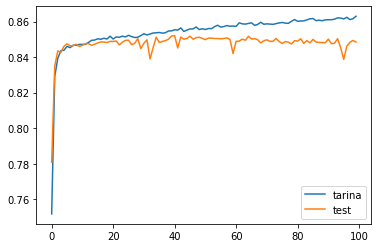

In [ ]:
import matplotlib.pyplot as pl
plt.plot(history_sgd.history['accuracy'], label = "tarina")
plt.plot(history_sgd.history['val_accuracy'], label = "test")
plt.legend()
plt.show()

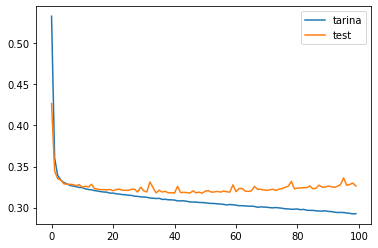

In [ ]:
import matplotlib.pyplot as pl
plt.plot(history_sgd.history['loss'], label = "tarina")
plt.plot(history_sgd.history['val_loss'], label = "test")
plt.legend()
plt.show()

# RMSprop

In [7]:
RMSprop = keras.optimizers.RMSprop(learning_rate=0.001, rho=0.9)
model.compile(loss="binary_crossentropy",optimizer=RMSprop, metrics=["accuracy"])
model.fit(X_train, y_train, validation_data= (X_test, y_test), batch_size=32,epochs=100, callbacks=[history_sgd])

Epoch 1/100
772/943 [=======================>......] - ETA: 0s - loss: 0.3991 - accuracy: 0.8172

KeyboardInterrupt: ignored

In [8]:
history_sgd.history.keys()

dict_keys([])

In [ ]:
plt.plot(history_sgd.history['loss'], label = "tarina")
plt.plot(history_sgd.history['val_loss'], label = "test")
plt.legend()
plt.show()

In [ ]:
plt.plot(history_sgd.history['accuracy'], label = "tarina")
plt.plot(history_sgd.history['val_accuracy'], label = "test")
plt.legend()
plt.show()

# Adagrad

In [ ]:
Adagrad = keras.optimizers.Adagrad(learning_rate=0.01)
model.compile(loss="binary_crossentropy",optimizer=Adagrad, metrics=["accuracy"])

In [ ]:
model.fit(X_train, y_train, validation_data= (X_test, y_test), batch_size=32,epochs=100, callbacks=[history_sgd])

In [ ]:
history_sgd.history.keys()

In [ ]:
import matplotlib.pyplot as pl
plt.plot(history_sgd.history['accuracy'], label = "tarina")
plt.plot(history_sgd.history['val_accuracy'], label = "test")
plt.legend()
plt.show()

# Adadelta

In [ ]:
Adadelta = keras.optimizers.Adadelta(learning_rate=1.0, rho=0.95)
model.compile(loss="binary_crossentropy",optimizer=Adadelta, metrics=["accuracy"])

In [ ]:
model.fit(X_train, y_train, validation_data= (X_test, y_test), batch_size=32,epochs=100, callbacks=[history_sgd])

In [ ]:
history_sgd.history.keys()

In [ ]:
import matplotlib.pyplot as pl
plt.plot(history_sgd.history['accuracy'], label = "tarina")
plt.plot(history_sgd.history['val_accuracy'], label = "test")
plt.legend()
plt.show()

# Adam

In [ ]:
Adam = keras.optimizers.Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, amsgrad=False)
model.compile(loss="binary_crossentropy",optimizer=Adam, metrics=["accuracy"])


In [ ]:
model.fit(X_train, y_train, validation_data= (X_test, y_test), batch_size=32,epochs=100, callbacks=[history_sgd])

In [ ]:
history_sgd.history.keys()

In [ ]:
import matplotlib.pyplot as pl
plt.plot(history_sgd.history['accuracy'], label = "tarina")
plt.plot(history_sgd.history['val_accuracy'], label = "test")
plt.legend()
plt.show()

# Adam

In [ ]:
Adam = keras.optimizers.Adam(learning_rate=0.0001, beta_1=0.9, beta_2=0.999, amsgrad=False)
model.compile(loss="binary_crossentropy",optimizer=Adam, metrics=["accuracy"])


In [ ]:
model.fit(X_train, y_train, validation_data= (X_test, y_test), batch_size=32,epochs=100, callbacks=[history_sgd])

In [ ]:
history_sgd.history.keys()

In [ ]:
import matplotlib.pyplot as pl
plt.plot(history_sgd.history['accuracy'], label = "tarina")
plt.plot(history_sgd.history['val_accuracy'], label = "test")
plt.legend()
plt.show()